In [0]:
import torch
import numpy as np
import pandas as pd
import json
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import gensim
import string
import csv
import random
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from math import ceil
import warnings
warnings.filterwarnings("ignore")

# Parameters of the Process

In [2]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# GPU
useCuda = False
if torch.cuda.is_available():
  useCuda = True
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
print('I use cuda:',useCuda)

I use cuda: True


In [0]:
Colab = True

### Boolean for processes
boolW2V = False #Word to vec
boolCV = False # Cross validation
boolFT = False # Final training

### Book
books = ['Chance.txt','TheMirroroftheSea.txt','HeartofDarkness.txt','LordJim.txt','TheShadow-Line.txt']

### Parameters

# Dataset
w2v_size = 100
crop_len = 20
batch_size = 512

# Network
dropout_prob = 0.3

### Random seed
np.random.seed(17)
random.seed(17)

# Colab instructions

If I am using Colab, the path is specified.

In [4]:
if Colab:
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/'
else:
  path = ''      

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load of dataset 

The dataset is loaded and clean. Furthermore, just the most frequent words are considered.

#### Clean dictionary functions

In [0]:
def BuildText(path,books):
    
    # Read files
    text_list = [open(path+b, 'r').read() for b in books]

    # Build the dataset    
    text = ''
    for t in text_list:
        text += t

    return text

def Clean(input_text):
    # Lower case
    text = input_text.lower()

    # Remove space after a new line
    text = re.sub('\n[ ]+\n', '\n', text)

    # Substitute cases
    text = re.sub('['+'_'+']', ' ', text)
    text = re.sub('['+'—'+']', ' ', text)
    text = re.sub('['+'-'+']', ' ', text)
    text = re.sub('['+'“'+']', ' ', text)
    text = re.sub('['+'”'+']', ' ', text) 
    text = re.sub('['+'‘'+']', ' ', text) 
    text = re.sub('['+'’'+']', ' ', text) 
    # Keep just points and commas
    text = re.sub('['+','+']', ' '+'commapunct'+' ', text)
    text = re.sub('['+'.'+']', ' '+'pointpunct'+' ', text)
    text = re.sub('['+'!'+']', ' '+'exclapunct'+' ', text)
    text = re.sub('['+'?'+']', ' '+'questpunct'+' ', text)

    return text

In [0]:
class BookDataset(Dataset):
    
    def __init__(self, path, books, boolW2V, w2v_size, crop_len, transform=None):

        ### Preprocessing

        text = BuildText(path, books)      
        text = Clean(text)   
        self.text=text  
             
        ### Paragraph
        
        # Extract the paragraph
        par_list = re.split('\n\n', self.text)
        

        # Split paragraphs
        translator=str.maketrans('','',string.punctuation)
        par_list = [x.translate(translator).split() for x in par_list]
        par_list = [x for x in par_list if len(x) >= crop_len]
        
        # Considering all* the sequences inside a paragraph
        seq_list = []
        for par in par_list:
            index = len(par)-crop_len
            while index > 0:
                seq_list.append(crop(par,index,crop_len))
                index -= crop_len

        random.shuffle(seq_list)

        ### Store data
        self.par_list = par_list
        self.seq_list = seq_list  
        self.w2v_size = w2v_size
        self.crop_len = crop_len  
        self.transform = transform    

        # Indexes
        self.w2i = {}
        self.i2w = {}
        # Approximations
        self.w2a = {}

        self.W2V(boolW2V)
        

    def __len__(self):
        return len(self.seq_list)
        
    def __getitem__(self, idx):
        # Get paragraph text
        text = self.seq_list[idx]
        # Encode with numbers
        encoded = encode_text(self.w2i,text)
        # Create sample
        sample = {'text': text, 'encoded': encoded}

        # Transform
        if self.transform:
            sample = self.transform(sample)

        return sample

    def W2V(self, bool):

        if bool:

            ### Word to vector

            # Model
            word_model = gensim.models.Word2Vec(self.seq_list, size=self.w2v_size, min_count=1, window=5, workers=4, iter=200)
            words = list(word_model.wv.vocab)

            # Dictionaries for word2vec     
            # From index to word
            self.w2i = {w: i for i, w in enumerate(word_model.wv.index2word)}           
            # From word to index        
            self.i2w = {word_model.wv.vocab[w].index : w for w in words}   
            # From words to approximation
            self.w2a = { w : ' '+w for w in words }
            self.w2a['commapunct'] = ','
            self.w2a['pointpunct'] = '.'
            self.w2a['exclapunct'] = '!'
            self.w2a['questpunct'] = '?'

            ### Save

            # Save weights
            weights = torch.FloatTensor(word_model.wv.vectors)
            save_weights = path+'Embedding.torch'
            pathw = F"{save_weights}" 
            torch.save(weights, pathw)
            # Save dictionaries
            with open(path + 'i2w.json', 'w') as f:
                json.dump(self.i2w, f, indent=4)
            with open(path + 'w2i.json', 'w') as f:
                json.dump(self.w2i, f, indent=4)
            with open(path + 'w2a.json', 'w') as f:
                json.dump(self.w2a, f, indent=4)


            # Save model
            word_model.save(path+'word_model.bin')

            
            # Load dictionaries
            self.i2w = json.load(open(path + 'i2w.json'))
            self.w2i = json.load(open(path + 'w2i.json'))
            self.w2a = json.load(open(path + 'w2a.json'))


        else:

            # Load dictionaries
            self.i2w = json.load(open(path + 'i2w.json'))
            self.w2i = json.load(open(path + 'w2i.json'))
            self.w2a = json.load(open(path + 'w2a.json'))

                
    def Info(self):    

        print('Information about dataset')
        print('-------------------------')
        print('Number of paragraph:',len(self.par_list))
        print('Number of sequences:',len(self.seq_list))
        print('Number of vocabs:', len(self.i2w))
        print('-------------------------')

    def LenVocab(self):
        return len(self.i2w)


### Encode and Decode functions
        
def encode_text(dictionary,text):
    i = -1
    for w in text:
        i+=1
        try:
            temp = dictionary[w]
        except:
            text.remove(w)
    encoded = [dictionary[w] for w in text]
    return encoded
def decode_text(dictionary,code):
    text = [dictionary[str(i)] for i in code]
    return text

### Crop to build sentences 

def crop(par,index,crop_len):   
    start_idx = index
    end_idx = start_idx + crop_len
    return par[start_idx: end_idx]

In [0]:

# Class to prepare text for training
               
class ToTensor():    
    def __call__(self, sample):
        # Convert one hot encoded text to pytorch tensor
        encoded = torch.LongTensor(sample['encoded'])
        return {'encoded': encoded} 

In [8]:
# Transformation
trans = ToTensor()
# Dataset
dataset = BookDataset(path,books,boolW2V,w2v_size,crop_len,transform=trans)
dataset.Info()
vocab_len = dataset.LenVocab()

Information about dataset
-------------------------
Number of paragraph: 3549
Number of sequences: 21665
Number of vocabs: 17246
-------------------------


In [0]:
# Check on the length of the sentences
for seq in dataset:
  if len(seq['encoded'])!=20:
    print(len(seq['encoded']))

# Analysis of Word2Vec


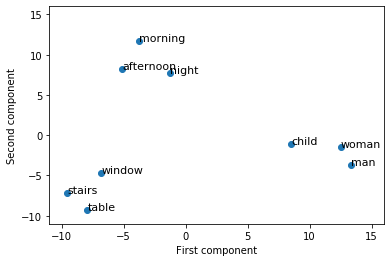

In [10]:
model = gensim.models.Word2Vec.load(path+'word_model.bin')

name = ['stairs','window','table','morning','night','afternoon','woman','man','child']
vector = model[name]

pca = PCA(n_components=2)
result = pca.fit_transform(vector)

plt.scatter(result[:,0],result[:,1])
for i, word in enumerate(name):
    plt.annotate(word,xy=(result[i,0],result[i,1]),fontsize=11)
plt.xlim(-11,+16)
plt.ylim(-11,+16)
plt.xticks(np.arange(-10,16,5))
plt.yticks(np.arange(-10,16,5))
plt.xlabel('First component')
plt.ylabel('Second component')
plt.savefig(path+'w2v.png')
plt.show()

# Training and Validation sets

In [11]:
torch.manual_seed(int(17))
train, val = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])
print('Information about training and validation set')
print('---------------------------------------------')
print('Size of training set:',len(train))
print('Size of validation set:',len(val))
print('---------------------------------------------')

Information about training and validation set
---------------------------------------------
Size of training set: 17332
Size of validation set: 4333
---------------------------------------------


# Neural Network

In [0]:
class Network(nn.Module):
    
    def __init__(self, vocab_len, w2v_size, hidden_units, layers_num, dropout_prob=0):
        # Call the parent init function (required!)
        super().__init__()
        
        # Input layer for embedding
        #read weights
        w2vweight = torch.load(path+'Embedding.torch')
        w2vweight = torch.FloatTensor(w2vweight)

        #vocab_len -> w2v_size
        self.embedding = nn.Embedding(vocab_len, w2v_size).from_pretrained(w2vweight)
        # Do not train the embedding layer
        self.embedding.weight.requires_grad=False  

        # LSTM 
        #w2v_size -> hidden_units
        self.rnn = nn.LSTM(input_size=w2v_size, 
                           hidden_size=hidden_units,
                           num_layers=layers_num,
                           dropout=dropout_prob,
                           batch_first=True)
        
        # Output
        #hidden_units -> vocab_len
        self.out = nn.Linear(hidden_units, vocab_len)
        
    def forward(self, x, state=None):
        # Embedding
        x = self.embedding(x)
        # LSTM
        x, rnn_state = self.rnn(x, state)
        # Linear layer
        output = self.out(x)

        return output, rnn_state

# Training 

In [0]:
 class TrainPredict():

    def __init__(self, net, dataset, train, val, batch_size):
        self.net = net
        self.dataset = dataset
        # Saving bacthes
        self.train = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=1)
        self.val = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=1)      
        # Saving loss
        self.loss_train = []
        self.loss_val = []

        # Print information about batches
        print('-------------------------------------------')
        print('Number of training batches:', ceil(len(train)/batch_size))
        print('Number of validation batches:', ceil(len(val)/batch_size))
        print('-------------------------------------------')
        
    # Train a single batch
    def train_batch(self, e, batch, loss_fn, optimizer):

        # Get the labels (the last letter of each sequence) and input
        X, y = batch[:, :-1], batch[:, 1:]
        # Eventually clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        y_pred, _ = self.net(X)
        # Evaluate loss only for last output
        loss = loss_fn(y_pred.transpose(1, 2), y)

        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
     
        # Return average batch loss
        return float(loss.data)

    # Evaluate a single batch
    def eval_batch(self, e, batch, loss_fn):
 
        # Get the labels (the last letter of each sequence) and input
        X, y = batch[:, :-1], batch[:, 1:]
        with torch.no_grad(): # Avoid tracking the gradients (much faster!)
            y_pred, _ = self.net(X)
        # Evaluate loss only for last output
        loss = loss_fn(y_pred.transpose(1, 2), y)

        # Return average batch loss
        return float(loss.data)

    # Training function
    def training(self, n_epochs, verbose):
        
        if useCuda:
          torch.cuda.empty_cache()

        # Define Optimizer, Scheduler and Loss 
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.net.parameters()),lr=1e-3, weight_decay=5e-4)

        loss_fn = nn.CrossEntropyLoss()

        # Epochs
        lt = []
        lv = []
        for epoch in range(n_epochs):

                if((epoch+1)%2 == 0 and verbose):
                      print('##################################')
                      print('## EPOCH %d' % (epoch + 1))
                      print('##################################')

                ### Training

                # Iterate batches
                # Training mode
                self.net.train() 
                for batch_sample in self.train:
                    # Extract batch
                    batch = batch_sample['encoded'].to(device)
                    # Update network
                    batch_loss = self.train_batch(epoch, batch, loss_fn, optimizer)
                    # Save loss
                    lt.append(batch_loss)            

                if((epoch+1)%2 == 0 and verbose):
                    print('\t Training loss:', np.mean(np.array(lt)))


                if((epoch+1)%1 == 0):
                    self.loss_train.append(np.mean(np.array(lt))) 
                    lt = []

                ### Validation

                # Iterate batches
                # Eval mode
                self.net.eval()
                for batch_sample in self.val:
                    # Extract batch
                    batch = batch_sample['encoded'].to(device)
                    # Update network
                    batch_loss = self.eval_batch(epoch, batch, loss_fn)
                    # Save loss
                    lv.append(batch_loss)

                if((epoch+1)%2 == 0  and verbose):
                      print('\t Validation loss :', np.mean(np.array(lv)))

                if((epoch+1)%1 == 0):
                    self.loss_val.append(np.mean(np.array(lv)))
                    lv = []                     

                # Save weights
                if (epoch+1)%5:
                    # Save network parameters
                    torch.save(self.net.state_dict(), path+'net_params.pth')

                if epoch > 30:
                    # prevent overfitting
                    k = 0
                    for i in range(30):
                      index=len(self.loss_val)-1
                      if self.loss_val[index-i]>self.loss_val[index-i-1]: 
                        k+=1
                    if k>= 20: 
                        print('Early stopping at epoch', epoch)
                        ### Save final weights                
                        # Save network parameters
                        torch.save(self.net.state_dict(),path+'net_params.pth')
                        break

        ### Save final weights                
        torch.save(self.net.state_dict(), path+ 'net_params.pth')

        return self.loss_train, self.loss_val

    # Prediction
    def predict(self,input_seed,n):

        seed = Clean(input_seed)
        translator=str.maketrans('','',string.punctuation)
        seed = seed.translate(translator).split() 

        # Evaluation mode
        self.net.eval() 

        ###  Find initial state of the RNN
        with torch.no_grad():
            # Encode seed
            seed_encoded = encode_text(self.dataset.w2i, seed)
            # To tensor
            seed_tensor = torch.LongTensor(seed_encoded)
            # Add batch axis
            seed_tensor = seed_tensor.unsqueeze(0).to(device)
            # Forward pass
            net_out, net_state = self.net(seed_tensor)
        # Get the most probable last output index
        next_encoded = self.next_softmax(net_out[:, -1, :])
        # Print the seed letters
        print(input_seed, end='', flush=True)

        next_decoded = self.dataset.i2w[str(next_encoded)]
        print(self.dataset.w2a[next_decoded], end='', flush=True)

        ### Generate sentences

        tot_count = 0
        while True:
            with torch.no_grad(): # No need to track the gradients
                # The new network input is the one hot encoding of the last chosen letter
                net_input = torch.LongTensor([next_encoded])
                net_input = net_input.unsqueeze(0).to(device)
                # Forward pass
                net_out, net_state = self.net(net_input, net_state)
                # Get the most probable letter index
                next_encoded = self.next_softmax(net_out[:, -1, :])
               
                # Decode the letter
                next_decoded = self.dataset.i2w[str(next_encoded)]
                print(self.dataset.w2a[next_decoded], end='', flush=True)
                # Count total letters
                tot_count += 1
                # Break if n words
                if tot_count > n:
                    break

    def next_softmax(self,x):
        #returns the word
        with torch.no_grad():
            out = nn.functional.softmax(x,dim=1)
            vocab = np.arange(out.shape[1])
            sampling = out.reshape(-1,).cpu().detach().numpy()
            predicted = np.random.choice(vocab, p=sampling/sum(sampling))
        return predicted.item()


# Cross Validation

In [0]:
class CrossValidation():
    def __init__(self, dataset, train, folds, layers, hidden_units):
        self.dataset = dataset
        self.train = train
        self.folds = folds
        self.layers = layers
        self.hidden_units = hidden_units
        self.losses = []
        self.best = []
    
    def one_par(self, par, batch_size):

        # Print
        print('---------------------------------------------------------------')
        print('Number layers:',self.layers[par])
        print('Hidden units:',self.hidden_units[par])
        print('---------------------------------------------------------------')

        # Losses
        l = 0
        # Kfold
        kf = KFold(n_splits=self.folds,random_state=17)
        kf.get_n_splits(self.train)

        # Start cross validation
        for train_index, val_index in kf.split(self.train):
            train_index = list(train_index)
            val_index = list(val_index)
            ktrain = torch.utils.data.Subset(self.train, train_index)
            kval= torch.utils.data.Subset(self.train, val_index)
            # Build network
            knet = Network(vocab_len, w2v_size, self.hidden_units[par], self.layers[par], dropout_prob)
            knet = knet.to(device) 
            print(knet)
            TP = TrainPredict(knet, self.dataset, ktrain, kval, batch_size)
            print('Prediction before training:')
            seed = 'You are'
            TP.predict(seed,20)

            # Training            
            losst, lossv =  TP.training(100, False)

            # Plot
            e = np.arange(len(losst))
            plt.plot(e,losst, label='Training loss')
            plt.plot(e,lossv, label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            seed = 'The people want'
            TP.predict(seed,30)
            print('\n')
            seed = 'There were'
            TP.predict(seed,30)
            print('\n')
            seed = 'She was going to'
            TP.predict(seed,30)
            print('\n','---------------------------------------------------------------')

            l += lossv[-1]

        # Save losses
        self.losses.append(l/self.folds)
        
        print('Loss:',self.losses[-1])

    def Validate(self, bool, batch_size):

        if bool:
          for par in range(len(self.layers)):
              self.one_par(par, batch_size)

          best = np.argmin(np.array(self.losses))
          self.best.append(self.hidden_units[best])
          self.best.append(self.layers[best])
          self.best.append(self.losses[best])
          return self.best

  

# Result of the cross validation

In [0]:
cv = CrossValidation(dataset,train,3,layers=[2,2,2],hidden_units=[32,64,128])
best = cv.Validate(boolCV, batch_size)
best

In [0]:
cv = CrossValidation(dataset,train,3,layers=[3,3,3],hidden_units=[32,64,128])
best = cv.Validate(boolCV, batch_size)
best

# Final Training

In [0]:
if boolFT:
  best = [128,2]
  net = Network(vocab_len, w2v_size, best[0], best[1], dropout_prob)
  net = net.to(device) 
  print(net)
  TP = TrainPredict(net, dataset, train, val, batch_size)
  losst, lossv =  TP.training(500, True)

In [0]:
if boolFT:
  # Plot
  plt.plot(losst, label='Training loss')
  plt.plot(lossv, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  #plt.yscale('log')
  plt.savefig(path+'loss.png')
  plt.show()

In [0]:
if boolFT:
  seed = 'The people want'
  TP.predict(seed,30)
  print('\n')
  seed = 'There were'
  TP.predict(seed,30)
  print('\n')
  seed = 'She was going to'
  TP.predict(seed,30)